In [1]:
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.observations.observation import EddiesObservations

import os, glob
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from numpy import arange
import xarray as xr
from netCDF4 import Dataset

In [3]:
# Function to convert longitude from 0..360 to -180..180

def modify_lon(eddy_file):
    foo =  Dataset(eddy_file, "a")
    foo.variables['longitude'][:] = foo.variables['longitude'][:] - 360
    foo.variables['longitude_max'][:] = foo.variables['longitude_max'][:] - 360
    foo.variables['effective_contour_longitude'][:] = foo.variables['effective_contour_longitude'][:] -360
    foo.variables['speed_contour_longitude'][:] = foo.variables['speed_contour_longitude'][:] - 360
    foo.close
    
def PyEddy(hycom_file, directory_out, pre_filter = False, plot_png = False):

    # Load hycom data (adt = ssh, ugos, vgos)
    hycom = RegularGridDataset(hycom_file, 'lon', 'lat')
    
    # Extract Date from file
    date = os.path.basename(hycom_file)[15:23]
    print(date, int(date[0:4]), int(date[4:6]), int(date[6:8]))
    
    #Apply a high-pass filter to remove the large scale and highlight the mesoscale
    if pre_filter:
        hycom.bessel_high_filter('adt', 500, order=3)  # 500 km
        
    a, c = hycom.eddy_identification(
        'adt', 'ugos', 'vgos',    # Variables used for identification
        datetime(int(date[0:4]), int(date[4:6]), int(date[6:8])),
        0.005,                    # step between two isolines of detection (m)
        pixel_limit=(100, 200000),  # Min and max pixel count for valid contour
        shape_error=55)           # Error max (%) between ratio of circle fit and contour

    print(type(a))
    with Dataset(directory_out + '/Anticyclonic_' + date + '.nc', 'w') as h:
        a.to_netcdf(h)
    with Dataset(directory_out + '/Cyclonic_' + date + '.nc', 'w') as h:
        c.to_netcdf(h)

    modify_lon(directory_out + '/Anticyclonic_' + date + '.nc') 
    modify_lon(directory_out + '/Cyclonic_' + date + '.nc')  
    
    if plot_png:
        
        # Read in lon corrected eddy files
        a = EddiesObservations.load_file(directory_out + '/Anticyclonic_' + date + '.nc')
        c = EddiesObservations.load_file(directory_out + '/Cyclonic_' + date + '.nc')
        
        fig = plt.figure(figsize=(8, 6), dpi=80)
        ax = fig.add_axes([.03,.03,.94,.94])
        hycom.display(ax, 'adt', vmin=-0.3, vmax=0.3, cmap='viridis')
        a.display(ax, color="r", lw=2) 
        c.display(ax, color="w", lw=2)
        
        plt.savefig(directory_out + '/Eddies_' + date + '.png')

In [ ]:
#GREG VERSION
hycom_in = sorted(glob.glob('/media/gsilsbe/modis1/gom/hycom/aviso_in/hycom_gomu_501_2003*.nc'))
directory_out = 'other'

for i in hycom_in:
    PyEddy(i, directory_out, pre_filter = True, plot_png = True)

In [22]:
def modify_lon(eddy_file):
    foo =  Dataset(eddy_file, "a")
    foo.variables['longitude'][:] = foo.variables['longitude'][:] - 360
    foo.variables['longitude_max'][:] = foo.variables['longitude_max'][:] - 360
    foo.variables['effective_contour_longitude'][:] = foo.variables['effective_contour_longitude'][:] -360
    foo.variables['speed_contour_longitude'][:] = foo.variables['speed_contour_longitude'][:] - 360
    foo.close
    

def PyEddy(hycom_file, directory_out, pre_filter = False, plot_png = False):

    # Load hycom data (adt = ssh, ugos, vgos)
    hycom = RegularGridDataset(hycom_file, 'lon', 'lat')
    
    # Extract Date from file
    date = os.path.basename(hycom_file)[15:23]
    print(date, int(date[0:4]), int(date[4:6]), int(date[6:8]))
    
    if pre_filter:
        hycom.bessel_high_filter('adt', 500, order=3)  # 500 km
        
    a, c = hycom.eddy_identification(
        'adt', 'ugos', 'vgos',    # Variables used for identification
        datetime(int(date[0:4]), int(date[4:6]), int(date[6:8])),
        0.01,                    # step between two isolines of detection (m)
        pixel_limit=(100, 200000),  # Min and max pixel count for valid contour
        shape_error=55)           # Error max (%) between ratio of circle fit and contour

    print(type(a))
    with Dataset(directory_out + '/Anticyclonic_' + date + '_steps_bet_isolines_.01'  + '.nc', 'w') as h:
        a.to_netcdf(h)
    with Dataset(directory_out + '/Cyclonic_' + date + '_steps_bet_isolines_.01'  + '.nc', 'w') as h:
        c.to_netcdf(h)

    modify_lon(directory_out + '/Anticyclonic_' + date + '_steps_bet_isolines_.01' + '.nc') 
    modify_lon(directory_out + '/Cyclonic_' + date + '_steps_bet_isolines_.01' + '.nc')  
    
    if plot_png:
        
        # Read in lon corrected eddy files
        a = EddiesObservations.load_file(directory_out + '/Anticyclonic_' + date + '_shape_err_65' + '.nc')
        c = EddiesObservations.load_file(directory_out + '/Cyclonic_' + date + '_shape_err_65' + '.nc')
        
        fig = plt.figure(figsize=(8, 6), dpi=80)
        ax = fig.add_axes([.03,.03,.94,.94])
        m = hycom.display(ax, 'adt', vmin=-0.3, vmax=0.3, cmap='viridis', label="Sea Surface Height")
        a.display(ax, extern_only=True, label='Anticyclonic ({nb_obs} eddies)',color='r',lw=3,ls='solid') 
        c.display(ax, extern_only=True, label="Cyclonic ({nb_obs} eddies)", color="k", lw=3,ls='solid')
        cb = plt.colorbar(m,location='bottom',format='%.2f',shrink=.6,pad=.06)
        cb.ax.set_xlabel('SSH (m)',fontsize=15)#label the colorbar
        _= ax.legend(loc="best")
        
        #plt.savefig(directory_out + '/Eddies_' + date + '.png')

In [23]:
dir = "/data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/"
hycom_in = dir + "hycom_gomu_501_2006030900_t000.nc"
directory_out = "/data/watkinson/Summer2022/data/eddies/Adjust_step_bet_isolines/20060309"

PyEddy(hycom_in, directory_out,pre_filter = True, plot_png = False)

We assume pixel position of grid is centered for /data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc


20060309 2006 3 9


/data/watkinson/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


<class 'py_eddy_tracker.observations.observation.EddiesObservations'>


In [16]:
dir = "/data/watkinson/Summer2022/data/eddies/Adjust_step_bet_isolines/20060309/"
a = EddiesObservations.load_file(dir + 'Anticyclonic_20060309_steps_bet_isolines_.01.nc')
c = EddiesObservations.load_file(dir + 'Cyclonic_20060309_steps_bet_isolines_.01.nc')
hycom_in = "/data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc"
import xarray as xr
SSH_data = xr.open_dataset(hycom_in)
#print(SSH_data)

hycom = RegularGridDataset(hycom_in, 'lon', 'lat')

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_axes([.03,.03,.94,.94])
ax.set_title('Eddes and SSH on 03/09/06: Shape err=55%, Steps bet. isolines=.01',fontsize=15)#,fontweight='bold')
#a.display(ax, extern_only=True, label='Anticyclonic ({nb_obs} eddies)',color='r',lw=3,ls='solid') 
#c.display(ax, extern_only=True, label="Cyclonic ({nb_obs} eddies)", color="k", lw=3,ls='solid')
hycom.contours.display(ax,only_unused=True)
import numpy as np
lat=SSH_data.lat
lon=SSH_data.lon
ssh = SSH_data.adt
print(np.min(ssh))
print(np.max(ssh))
lon2d,lat2d=np.meshgrid(lon,lat)
cf = ax.contourf(lon2d,lat2d,ssh[:,:,0],cmap='viridis',levels=np.linspace(-.8,.6,400))
cl = ax.contour(lon2d,lat2d,ssh[:,:,0],colors='w',alpha=.7,levels=[-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6])
plt.clabel(cl, inline=1, fontsize=10)
cbar = fig.colorbar(cf,location='bottom',format='%.2f',pad=.05)#shrink=.6,pad=.04)
cbar.ax.set_xlabel('SSH (m)',fontsize=20)
_= ax.legend(loc="best")

NameError: name 'EddiesObservations' is not defined

In [ ]:
hycom_in = sorted(glob.glob('/media/gsilsbe/modis1/gom/hycom/aviso_in/hycom_gomu_501_2003*.nc'))
directory_out = 'other'

for i in hycom_in:
    PyEddy(i, directory_out, pre_filter = True, plot_png = True)

In [42]:
dir = "/data/watkinson/Summer2022/data/eddies/"
import xarray as xr
ds = xr.open_dataset(dir + "META3.1exp_DT_allsat_Cyclonic_untracked_19930101_20200307.nc")
ds1 = ds.time[232289]
#ds1 = ds.time.index['1993-01-01']
print(ds1)

<xarray.DataArray 'time' ()>
array('2007-12-14T00:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    axis:           T
    comment:        Date of this observation
    long_name:      Time
    standard_name:  time
    min:            15706
    max:            25633


We assume pixel position of grid is centered for /data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc


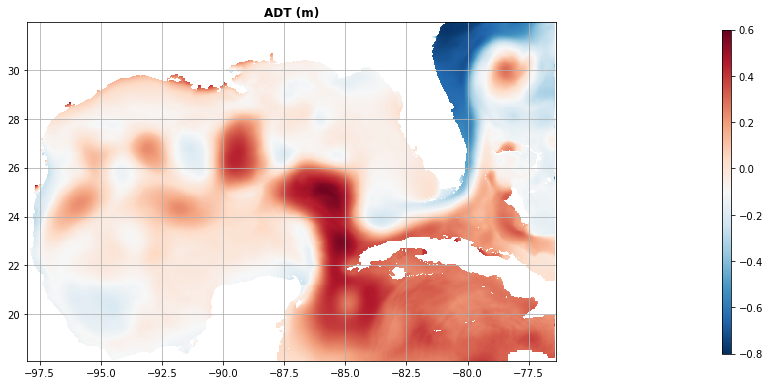

In [12]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset

def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    #ax.set_xlim(-6, 36.5), ax.set_ylim(30, 46)
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
        
g = RegularGridDataset(("/data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc"),
    "lon",
    "lat",
)

ax = start_axes("ADT (m)")

m = g.display(ax, "adt", vmin=-.8, vmax=.6, cmap="RdBu_r")
update_axes(ax, m)

In [13]:
#g.bessel_high_filter("adt", 500)
import os
date = os.path.basename("/data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc")[15:23]
print(date, int(date[0:4]), int(date[4:6]), int(date[6:8]))

a, c = g.eddy_identification(
        'adt', 'ugos', 'vgos',    # Variables used for identification
        datetime(int(date[0:4]), int(date[4:6]), int(date[6:8])),
        0.01,                    # step between two isolines of detection (m)
        pixel_limit=(100, 200000),  # Min and max pixel count for valid contour
        shape_error=55)

20060309 2006 3 9


In [51]:
hycom_in = "/data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc"
import xarray as xr
SSH_data = xr.open_dataset(hycom_in)
def modify_lon(eddy_file):
    foo =  Dataset(eddy_file, "a")
    foo.variables['longitude'][:] = foo.variables['longitude'][:] - 360
    foo.variables['longitude_max'][:] = foo.variables['longitude_max'][:] - 360
    foo.variables['effective_contour_longitude'][:] = foo.variables['effective_contour_longitude'][:] -360
    foo.variables['speed_contour_longitude'][:] = foo.variables['speed_contour_longitude'][:] - 360
    foo.close

hycom = RegularGridDataset(hycom_in, 'lon', 'lat')


hycom.bessel_high_filter("adt", 500)

date = os.path.basename("/data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc")[15:23]
print(date, int(date[0:4]), int(date[4:6]), int(date[6:8]))

a, c = hycom.eddy_identification(
        'adt', 'ugos', 'vgos',    # Variables used for identification
        datetime(int(date[0:4]), int(date[4:6]), int(date[6:8])),
        0.01,                    # step between two isolines of detection (m)
        pixel_limit=(100, 200000),  # Min and max pixel count for valid contour
        shape_error=55)
modify_lon(a)
modify_lon(c)
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_axes([.03,.03,.94,.94])
ax.set_title('Eddes and SSH on 03/09/06: Shape err=55%, Steps bet. isolines=.01',fontsize=15)#,fontweight='bold')
a.display(ax, extern_only=True, label='Anticyclonic ({nb_obs} eddies)',color='r',lw=3,ls='solid') 
c.display(ax, extern_only=True, label="Cyclonic ({nb_obs} eddies)", color="k", lw=3,ls='solid')
hycom.contours.display(ax,only_unused=True)
import numpy as np
lat=SSH_data.lat
lon=SSH_data.lon
ssh = SSH_data.adt
print(np.min(ssh))
print(np.max(ssh))
lon2d,lat2d=np.meshgrid(lon,lat)
cf = ax.contourf(lon2d,lat2d,ssh[:,:,0],cmap='viridis',levels=np.linspace(-.8,.6,400))
cl = ax.contour(lon2d,lat2d,ssh[:,:,0],colors='w',alpha=.7,levels=[-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6])
plt.clabel(cl, inline=1, fontsize=10)
cbar = fig.colorbar(cf,location='bottom',format='%.2f',pad=.05)#shrink=.6,pad=.04)
cbar.ax.set_xlabel('SSH (m)',fontsize=20)

_= ax.legend(loc="best")

We assume pixel position of grid is centered for /data/watkinson/Summer2022/data/hycom_ssh/Daily_SSH_files/hycom_gomu_501_2006030900_t000.nc


20060309 2006 3 9


/data/watkinson/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/data/watkinson/anaconda3/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:302: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


TypeError: stat: path should be string, bytes, os.PathLike or integer, not EddiesObservations

In [44]:
print(g.variables)

dict_keys(['time', 'lon', 'lat', 'adt', 'ugos', 'vgos'])


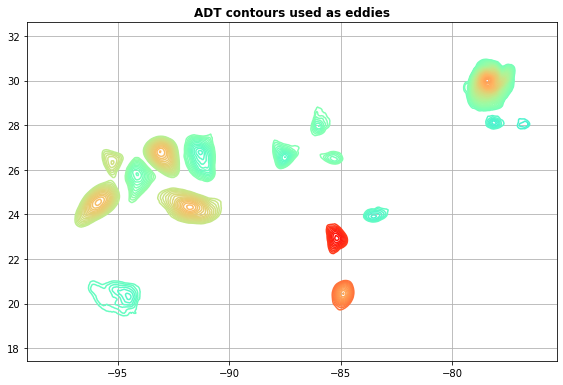

In [14]:
ax = start_axes("ADT contours used as eddies")

g.contours.display(ax, only_used=True)
update_axes(ax)

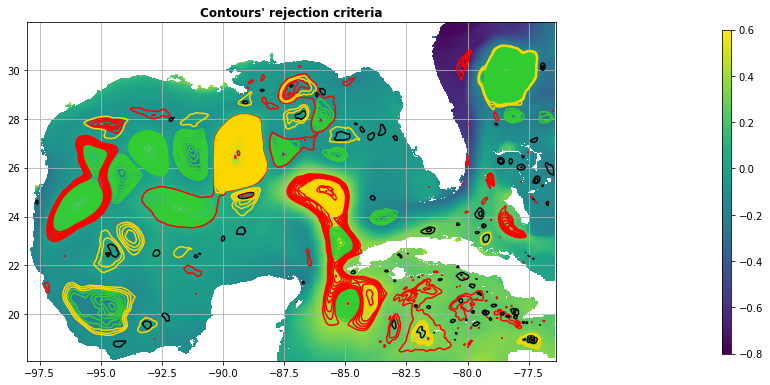

In [15]:
ax = start_axes("Contours' rejection criteria")
m = g.display(ax, "adt", vmin=-.8, vmax=.6, cmap="viridis")
g.contours.display(ax,display_criterion=True)# only_unused=True,display_criterion=True)
update_axes(ax, m)
#update_axes(ax)